# Binary Classification

## Load Dataset from sklearn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [3]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [4]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'class'],
      dtype='object')

## Convert to PyTorch Tensor

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from copy import deepcopy

In [6]:
data = torch.from_numpy(df.values).float()

data.shape

torch.Size([569, 31])

In [7]:
x = data[:, :30]
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([569, 30]) torch.Size([569, 1])


In [8]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]

In [9]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 341 / Valid 113 / Test 115 samples.


In [10]:
# random selection
indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


## Set Hyper Parameters

In [11]:
n_epochs = 10000
batch_size = 128
print_interval = 500
early_stop = 100

## Get DataLoaders

In [13]:
class CustomDataset(Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
        super().__init__()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [14]:
train_loader = DataLoader(
    dataset=CustomDataset(x[0], y[0]),
    batch_size=batch_size,
    # Allow shuffling only for training set.
    shuffle=True, 
)

valid_loader = DataLoader(
    dataset=CustomDataset(x[1], y[1]),
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=CustomDataset(x[2], y[2]),
    batch_size=batch_size,
    shuffle=False,
)

print("Train %d / Valid %d / Test %d samples." % (
    len(train_loader.dataset),
    len(valid_loader.dataset),
    len(test_loader.dataset),
))

Train 341 / Valid 113 / Test 115 samples.


In [15]:
len(train_loader)

3

## Build Model & Optimizer

In [16]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
    nn.Sigmoid(),
)

optimizer = optim.Adam(model.parameters())

## Train

In [17]:
lowest_loss = np.inf
lowest_epoch = np.inf
best_model = None

In [18]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    
    # We can remove code block for shuffle and split.

    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in train_loader:
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss)   # This is very important to prevent memory leak.

    train_loss = train_loss / len(train_loader)
    
    model.eval()
    
    with torch.no_grad():
        valid_loss = 0
        
        for x_i, y_i in valid_loader:
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(valid_loader)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.5f  valid_loss=%.5f  lowest_loss=%.5f' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.5f" % (lowest_epoch + 1, lowest_loss))

# load best model
model.load_state_dict(best_model)

Epoch 500: train loss=0.15663  valid_loss=0.13388  lowest_loss=0.13596
Epoch 1000: train loss=0.12129  valid_loss=0.06902  lowest_loss=0.06975
Epoch 1500: train loss=0.09207  valid_loss=0.05750  lowest_loss=0.05711
There is no improvement during last 100 epochs.
The best validation loss from epoch 1654: 0.05604


<All keys matched successfully>

## Loss History

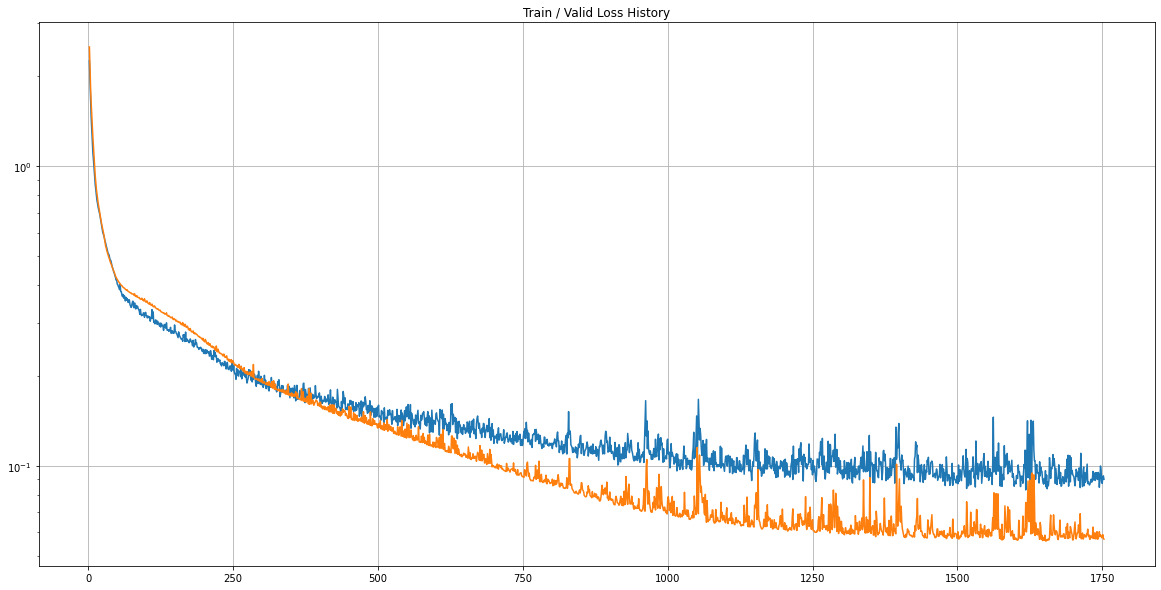

In [19]:
plot_from = 2

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## Test result

In [20]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad():
    for x_i, y_i in test_loader:
        y_hat_i = model(x_i)
        
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        test_loss += loss   # Gradient is already detached. float() is not required.

        y_hat += [y_hat_i]

test_loss = test_loss / len(test_loader)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.5f" % test_loss)

Test loss: 0.08497


In [21]:
correct_cnt = (y[2] == (y_hat > .5)).sum()
total_cnt = float(y[2].size(0))

print('Test Accuracy: %.4f' % (correct_cnt / total_cnt))

Test Accuracy: 0.9652
